In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
import scipy 

import random

import pandas as pd 
import os 
from tqdm import tqdm 

import cv2 
from PIL import Image

import tensorflow as tf 
from tensorflow.keras import models, layers 

train_depth_left = "../Datasets/stereo/data_scene_flow/training/disp_occ_0"
train_depth_right = "../Datasets/stereo/data_scene_flow/training/disp_occ_1"
train_img_left = "../Datasets/stereo/data_scene_flow/training/image_2"
train_img_right = "../Datasets/stereo/data_scene_flow/training/image_3"

test_img_left = "../Datasets/stereo/data_scene_flow/testing/image_2"
test_img_right = "../Datasets/stereo/data_scene_flow/testing/image_3"

train_paths = [train_depth_left, train_depth_right, train_img_left, train_img_right]
test_paths = [None, None, test_img_left, test_img_right]

In [2]:
def linear_interpolation(shape, xyd):
    m, n = shape 
    ij, d = xyd[:, 1::-1], xyd[:, 2]
    f = scipy.interpolate.LinearNDInterpolator(ij, d, fill_value=0) 
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T 
    disparity = f(IJ).reshape(shape) 
    return disparity 

def load_depth(img_path): 
    depth_map = np.asarray(Image.open(img_path))/256
    x, y = np.where(depth_map > 0)
    d = depth_map[depth_map != 0]
    xyd = np.stack((y, x, d)).T 
    gt = linear_interpolation(depth_map.shape, xyd)
    return gt 


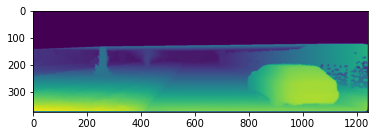

In [3]:
depth_path = "../Datasets/stereo/data_scene_flow/training/disp_occ_0/000018_10.png"
depth_map = load_depth(depth_path) 
plt.imshow(depth_map)
plt.show()

In [ ]:
# model ... 

# datagen = DataLoader(train_paths)
# for epoch in range(epochs):

#     batch = datagen.getBatch()      #32 

In [4]:
class DataLoader:

    def __init__(self, data_paths, shuffle = True, batch_size = 32, d_type="training", test_split = 0.2):
        ''' 
            Initializing loader parameters. Unpacks paths to image and depth image directories, and lists images inside them. 
            
            shuffle: Whether or not to shuffle the data
            batch_size: How many images to return everytime getBatch() function is called 
            d_type: Nature of the DataLoader object. Can be "training" or "testing". For testing, we do not need to unpack the depth maps
            test_split: How many images to use for training and validation. 
        '''

        self.depth_left, self.depth_right, self.img_left, self.img_right = data_paths           
        self.shuffle = shuffle 
        self.batch_size = batch_size 
        self.d_type = d_type
        self.test_split = 0.2 
        self.data = {
            "depth_left": [], 
            "depth_right": [], 
            "img_left": [], 
            "img_right": [] 
        }
        self.data_paths = os.listdir(self.depth_right)
        self.data_size = len(self.data_paths)

    def getLens(self):
        ''' 
            To find how many images we have in each unpacked directory
        '''
        for c in list(self.data.keys()):
            print(c, ":", len(self.data[c]))

    def load_paths(self):
        ''' 
            Loads the address of each image
        '''
        if self.d_type == "training": 
            self.data["img_left"] = [os.path.join(self.img_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Training Images", ncols=100)]
            self.data["depth_left"] = [os.path.join(self.depth_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Training Depths", ncols=100)] 
            self.data["img_right"] = [os.path.join(self.img_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Training Images", ncols=100)]
            self.data["depth_right"] = [os.path.join(self.depth_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Training Depths", ncols=100)]  

        else:
            self.data["img_left"] = [os.path.join(self.img_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Test Images", ncols=100)]
            self.data["img_right"] = [os.path.join(self.img_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Test Images", ncols=100)]

    def load_img(self, img_path):
        ''' 
            Reads an image from the mentioned address, followed by scaling
        '''
        # img = tf.io.read_file(img_path)
        # img = tf.image.decode_png(img, channels=3) 
        # return img/256
        img = np.asarray(Image.open(img_path))/256.
        return img  

    # @tf.function
    def linear_interpolation(self, shape, xyd_img): 
        ''' 
            Linear interpolation for the sparse ground truth depth map. This gives a better view of the depth map.
        '''
        m, n = shape 
        ij, d = xyd_img[:, 1::-1], xyd_img[:, 2]
        f = scipy.interpolate.LinearNDInterpolator(ij, d, fill_value=0) 
        J, I = np.meshgrid(np.arange(n), np.arange(m))
        IJ = np.vstack([I.flatten(), J.flatten()]).T 
        disparity = f(IJ).reshape(shape) 
        return disparity 
    
    # @tf.function
    def load_depth(self, depth_path):
        ''' 
            Reads a depth image from the mentioned address, followed by linear interpolation. 
        '''
        depth_map = self.load_img(depth_path) 
        x, y = np.where(depth_map > 0) 
        d = depth_map[depth_map != 0] 
        xyd = np.stack((y, x, d)).T 
        gt = self.linear_interpolation(depth_map.shape, xyd) 
        return gt 

    def getBatch(self):
        ''' 
            Returns a batch of "batch_size" number of images. Will be called in the training loop for some n number of times per epoch. 
        '''
        indices = random.sample(range(0, self.data_size), self.batch_size) 
        data = {
            "img_left": [self.load_img(self.data["img_left"][i]) for i in indices], 
            "img_right": [self.load_img(self.data["img_right"][i]) for i in indices], 
            "depth_left": [self.load_depth(self.data["depth_left"][i]) for i in indices], 
            "depth_right": [self.load_depth(self.data["depth_right"][i]) for i in indices]
        }            
        return data 

In [5]:
datagen = DataLoader(train_paths)
datagen.load_paths()

Loading Stereo Right Training Depths: 100%|███████████████████| 200/200 [00:00<00:00, 244494.55it/s]


In [6]:
datagen.getLens()

depth_left : 200
depth_right : 200
img_left : 200
img_right : 200


In [7]:
batch = datagen.getBatch()

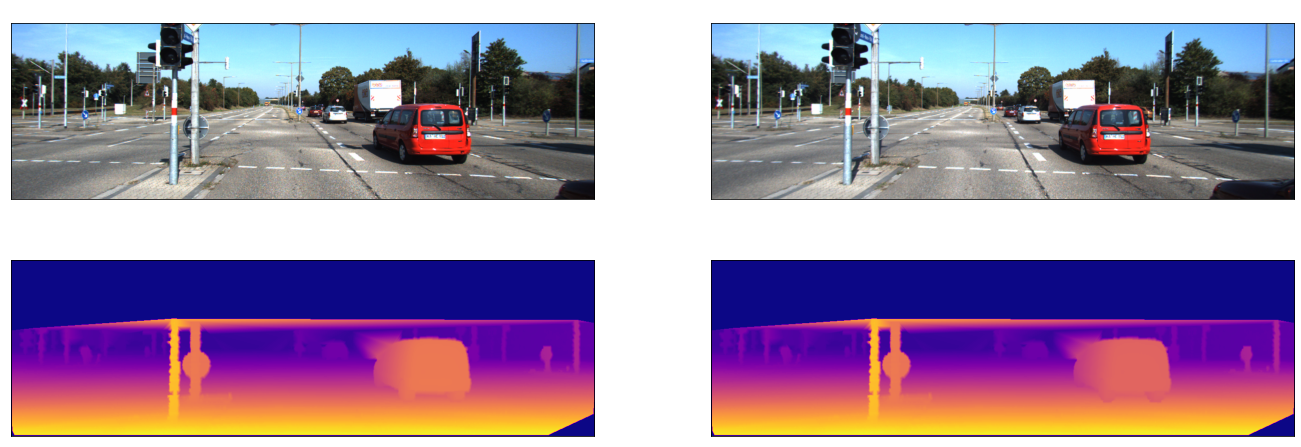

In [35]:
# it_il = iter(batch["img_left"])
# it_ir = iter(batch["img_right"])
plt.figure(figsize=(23, 8))

plt.subplot(221)
plt.imshow(batch["img_left"][0])
plt.title("Image Left", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(batch["depth_left"][0], cmap="plasma")
plt.title("Depth Left", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(batch["img_right"][0])
plt.title("Image Right", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(batch["depth_right"][0], cmap="plasma")
plt.title("Depth Right", color="white")
plt.xticks([])
plt.yticks([])

plt.show()


In [ ]:
#Rough Work Below

In [2]:
a = [1, 2, 3, 4, 5]
a[[4, 3, 2]]

TypeError: list indices must be integers or slices, not list

In [33]:
left = os.listdir(train_depth_left)
right = os.listdir(train_depth_right)

In [37]:
i1 = plt.imread(train_depth_left + "/" + left[1])
i2 = plt.imread(train_depth_right + "/" + right[1])

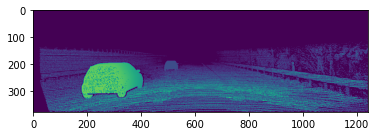

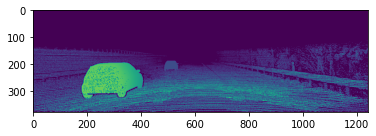

In [38]:
plt.imshow(i1)
plt.show()
plt.imshow(i2)
plt.show()

In [12]:
## Change this 
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=np.uint16)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png / 255.
    depth[depth_png == 0] = -1.
    return depth


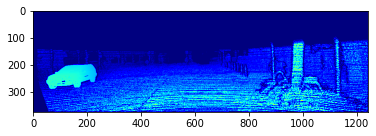

In [21]:
img_path = "Datasets/stereo/data_scene_flow/training/disp_noc_0/000001_10.png"

img = depth_read(img_path)
plt.imshow(img, plt.cm.jet)
plt.show()

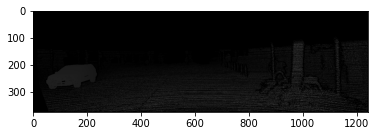

In [22]:
img = cv2.imread(img_path)
plt.imshow(img, cmap=plt.cm.jet)
plt.show()

In [16]:
img.shape

(375, 1242, 3)

In [19]:
def normalize(img_path):
    img = cv2.imread(img_path)
    return img + (255 - img.max())
    

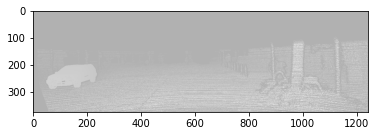

In [20]:
plt.imshow(normalize(img_path))